In [21]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score , f1_score , precision_score , recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import ast
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer
from numpy import nan
from numpy import inf
import statistics

# Utility functions

In [2]:
def cicid_preprocessing(data_set):
    data_set.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_set.dropna(inplace=True)
    return data_set.sort_index(axis=1)

In [3]:
def initialize_consumer(task_name):
    return KafkaConsumer(
    task_name,   
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [4]:
# get a fixed-sized window
def get_window(window_size,consumer,type):
    new_data = pd.DataFrame()
    current_index = 1
    for message in consumer:
        data_packet = message.value
        try:
            data_object = ast.literal_eval(data_packet.decode())
            new_data = new_data.append(data_object,ignore_index=True)
        except:
            current_index +=1
        if current_index == window_size:
            if type == 'binary':
                return cicid_preprocessing(new_data)
            else:
                return iot_preprocessing(new_data)

        current_index = current_index + 1
        

In [5]:
def iot_preprocessing(dataset):
    dataset = dataset.drop(columns=['Source'])
    dataset = dataset.sort_index(axis=1)
    return dataset

In [6]:
def kafka_stream(num_of_iterations,window_size,dataset,consumer,type):
    
    original_data = dataset.copy()

    results_static = {'accuracy':[],'f1-score':[]}
    results_adaptive =  {'accuracy':[],'f1-score':[]}
    
    chunk_number = num_of_iterations
    index = 0
    while index < chunk_number:

        new_stream_data = get_window(window_size,consumer,type)
        
        if type == 'binary':
            
            Y_test = new_stream_data['Label']
            X_test = new_stream_data.drop(columns=['Label'])        
            
            predicted_adaptive = cicids_adaptive.predict(X_test)
            predicted_static = cicids_static.predict(X_test)

            results_adaptive = calculate_predictions_binary(results_adaptive,predicted_adaptive,Y_test)
            results_static = calculate_predictions_binary(results_static,predicted_static,Y_test)

            #drop first n rows
            original_data = original_data.drop(original_data.index[0:window_size])
            #append n new rows to the original data
            original_data = pd.concat([original_data,new_stream_data],ignore_index=True)

            Y_train = original_data['Label']
            X_train = original_data.drop(columns=['Label'])

            # fit the adaptive model
            cicids_adaptive.fit(X_train, Y_train) 

        else:

            Y_test = new_stream_data['Class']
            X_test = new_stream_data.drop(columns=['Class'])   

            predicted_adaptive = iot_adaptive.predict(X_test)
            predicted_static = iot_static.predict(X_test)    

            #drop first n rows
            original_data = original_data.drop(original_data.index[0:window_size])
            #append n new rows to the original data
            original_data = pd.concat([original_data,new_stream_data],ignore_index=True) 
            
            results_adaptive = calculate_predictions_multi(results_adaptive,predicted_adaptive,Y_test)
            results_static = calculate_predictions_multi(results_static,predicted_static,Y_test)

            Y_train = original_data['Class']
            X_train = original_data.drop(columns=['Class'])

            # fit the adaptive model
            iot_adaptive.fit(X_train, Y_train)
                    

        index = index + 1
    return results_adaptive,results_static

In [7]:
def calculate_predictions_binary(results,y_pred,y_test):
    results['accuracy'].append(accuracy_score(y_test,y_pred))
    results['f1-score'].append(f1_score(y_test,y_pred,pos_label='ATTACK'))
    #results['precision'].append(precision_score(y_test,y_pred,pos_label='ATTACK'))
    #results['recall'].append(recall_score(y_test,y_pred,pos_label='ATTACK')) 
    return results

In [63]:
def calculate_predictions_multi(results,y_pred,y_test):
    results['accuracy'].append(accuracy_score(y_test,y_pred))
    results['f1-score'].append(f1_score(y_test,y_pred,average='micro'))
    return results

In [59]:
def plot_performance_metrics(results,num_of_iterations,window_size):
    for performance_type in results[0].keys():
        plt.plot(list(range(window_size,window_size*num_of_iterations+1,window_size)),results[1][performance_type],label='static')
        plt.plot(list(range(window_size,window_size*num_of_iterations+1,window_size)),results[0][performance_type],color='orange',label='adaptive')
        plt.plot(list(range(window_size,window_size*num_of_iterations+1,window_size)),[statistics.mean(results[1][performance_type])]*num_of_iterations,linestyle='dashed',label='static average',color='teal')
        plt.plot(list(range(window_size,window_size*num_of_iterations+1,window_size)),[statistics.mean(results[0][performance_type])]*num_of_iterations,color="green",linestyle='dashed',label='adaptive average')
        plt.legend()
        plt.title(performance_type)
        plt.show()

# Cicids Static data

In [10]:
cicidsDataset = pd.read_csv('cicids_static_data.csv',skipinitialspace=True)
cicidsDataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,159,2,2,68,266,34,34,34.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,51673,2,2,90,166,45,45,45.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,7496,43,1,1,0,6,0,0,0.0,0.0,...,40,0.0,0.0,0,0,0.0,0.0,0,0,ATTACK
3,46564,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,80,69,2,0,0,0,0,0,0.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [11]:
cicidsDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25191 entries, 0 to 25190
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             25191 non-null  int64  
 1   Flow Duration                25191 non-null  int64  
 2   Total Fwd Packets            25191 non-null  int64  
 3   Total Backward Packets       25191 non-null  int64  
 4   Total Length of Fwd Packets  25191 non-null  int64  
 5   Total Length of Bwd Packets  25191 non-null  int64  
 6   Fwd Packet Length Max        25191 non-null  int64  
 7   Fwd Packet Length Min        25191 non-null  int64  
 8   Fwd Packet Length Mean       25191 non-null  float64
 9   Fwd Packet Length Std        25191 non-null  float64
 10  Bwd Packet Length Max        25191 non-null  int64  
 11  Bwd Packet Length Min        25191 non-null  int64  
 12  Bwd Packet Length Mean       25191 non-null  float64
 13  Bwd Packet Lengt

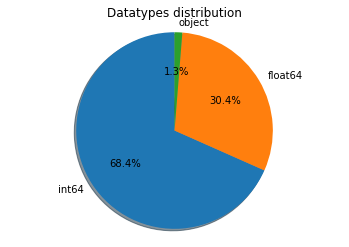

In [12]:
datatypes = ['int64', 'float64', 'object']

sizes = [len(cicidsDataset.select_dtypes(dt).columns) for dt in datatypes]
fig1, ax1 = plt.subplots()
plt.title("Datatypes distribution")
ax1.pie(sizes, labels=datatypes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### delete inf values

In [13]:
count = np.isinf(cicidsDataset.drop('Label',axis=1)).values.sum()
print("The data contains "+str(count)+" inf values")

The data contains 18 inf values


In [14]:
cicidsDataset.replace([np.inf, -np.inf], np.nan, inplace=True)
cicidsDataset.dropna(inplace=True)

### Sort Column indexes

In [15]:
cicidsDataset = cicidsDataset.sort_index(axis=1)

### Base Model

In [16]:
Y = cicidsDataset['Label']
X = cicidsDataset.drop(columns=['Label'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,stratify=Y,random_state=20)

clf = RandomForestClassifier().fit(X_train,y_train)
predicted = clf.predict(X_test)

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

      ATTACK       0.99      0.98      0.99       806
      BENIGN       1.00      1.00      1.00      7504

    accuracy                           1.00      8310
   macro avg       1.00      0.99      0.99      8310
weighted avg       1.00      1.00      1.00      8310



In [18]:
cicids_adaptive = RandomForestClassifier()
cicids_static = RandomForestClassifier()

cicids_adaptive.fit(X, Y)
cicids_static.fit(X, Y)

RandomForestClassifier()

## Kafka

In [19]:
# Kafka COnsumer
cicid_consumer = initialize_consumer('task1')

Average of accuracy for adaptive model :0.9971549989466085
Average of accuracy for static model :0.9971054212501955

Average of f1-score for adaptive model :0.985391552559074
Average of f1-score for static model :0.9851388914980862


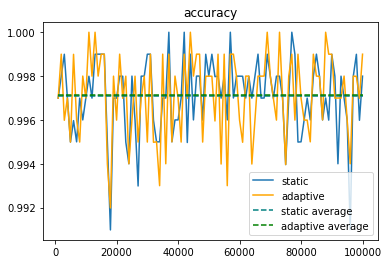

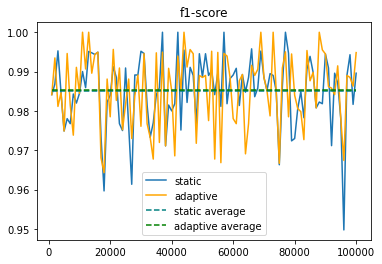

In [61]:
#num_of_iterations = 100
#window_size = 1000
#adaptive_cicid,static_cicid = kafka_stream(num_of_iterations,window_size,cicidsDataset,cicid_consumer,'binary')
print("Average of accuracy for adaptive model :"+str(statistics.mean(adaptive_cicid['accuracy'])))
print("Average of accuracy for static model :"+str(statistics.mean(static_cicid['accuracy'])))
print("")
print("Average of f1-score for adaptive model :"+str(statistics.mean(adaptive_cicid['f1-score'])))
print("Average of f1-score for static model :"+str(statistics.mean(static_cicid['f1-score'])))

plot_performance_metrics([adaptive_cicid,static_cicid],num_of_iterations,window_size)

# Iot Static Data

In [38]:
iot_data = pd.read_csv('iot_static_data.csv')
iot_data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Source,Class
0,19.570634,152.679121,39991.937640,20.937891,150.455024,38960.674060,23.168006,145.454142,36954.215040,33.115077,...,0.468843,4.999756,181.799689,2.276210e+02,290.439555,5.957202e+04,1.831480e+04,4.692557e-01,Provision PT 838 Security Camera,BENIGN
1,49.893840,169.297843,54532.338720,62.957476,169.735104,54283.995040,82.340884,168.919514,53449.819730,98.214224,...,0.000000,1.999960,69.999921,4.000000e+00,101.862598,1.600000e+01,0.000000e+00,0.000000e+00,Provision PT 737E Security Camera,BENIGN
2,1.996527,449.011775,409.365474,2.002395,448.141152,739.076602,2.166552,419.128740,11039.485060,4.621621,...,0.000000,14.978833,455.354366,1.959295e+01,455.354366,3.838837e+02,0.000000e+00,0.000000e+00,Samsung SNH 1011 N Webcam,BENIGN
3,1.000000,60.000018,0.004849,1.000065,60.017569,4.743299,1.063813,76.195918,4110.590208,2.936177,...,0.000000,7.290294,60.000000,9.540000e-07,84.852814,1.290000e-12,8.690000e-30,9.560000e-18,SimpleHome XCS7 1002 WHT Security Camera,BENIGN
4,100.707918,226.708372,54562.182272,155.736482,252.269792,58012.457557,446.854937,301.030305,60959.734097,4257.526218,...,0.000000,1.000000,554.000000,0.000000e+00,554.000000,0.000000e+00,0.000000e+00,0.000000e+00,Provision PT 838 Security Camera,mirai_udp_attack


In [39]:
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25609 entries, 0 to 25608
Columns: 117 entries, MI_dir_L5_weight to Class
dtypes: float64(115), object(2)
memory usage: 22.9+ MB


In [44]:
iot_data = iot_data.drop(columns=['Source'])

## Feature Importance

In [40]:
iot_data['Class'].value_counts()

BENIGN                   22287
mirai_udp_attack          1774
gafgyt_udp_attack          446
gafgyt_junk_attack         377
gafgyt_tcp_attack          213
gafgyt_scan_attack         200
mirai_syn_attack           101
mirai_ack_attack            96
mirai_scan_attack           86
gafgyt_combo_attack         18
mirai_udpplain_attack       11
Name: Class, dtype: int64

In [41]:
iot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
iot_data.dropna(inplace=True)

## Base Models

In [42]:
iot_data = iot_data.sort_index(axis=1)

In [45]:
Y = iot_data['Class']
X = iot_data.drop(columns=['Class'])

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, Y, stratify=Y, train_size=0.75)

clf = RandomForestClassifier(random_state=0).fit(X_train,y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid,y_pred))

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      5572
  gafgyt_combo_attack       1.00      0.50      0.67         4
   gafgyt_junk_attack       0.99      0.99      0.99        94
   gafgyt_scan_attack       0.96      1.00      0.98        50
    gafgyt_tcp_attack       1.00      0.96      0.98        53
    gafgyt_udp_attack       0.97      1.00      0.98       112
     mirai_ack_attack       1.00      1.00      1.00        24
    mirai_scan_attack       1.00      1.00      1.00        22
     mirai_syn_attack       1.00      1.00      1.00        25
     mirai_udp_attack       1.00      1.00      1.00       444
mirai_udpplain_attack       1.00      1.00      1.00         3

             accuracy                           1.00      6403
            macro avg       0.99      0.95      0.96      6403
         weighted avg       1.00      1.00      1.00      6403



In [47]:
iot_adaptive = RandomForestClassifier().fit(X,Y)
iot_static = RandomForestClassifier().fit(X,Y)

## Kafka

In [48]:
## Kafka
def iot_preprocessing(data_set):
    data_set = data_set.drop(columns=['Source'])
    data_set.sort_index
    return data_set

In [49]:
iot_consumer = initialize_consumer('task2')

Average of accuracy for adaptive model :0.99941
Average of accuracy for static model :0.9992

Average of f1-score for adaptive model :0.99941
Average of f1-score for static model :0.9992


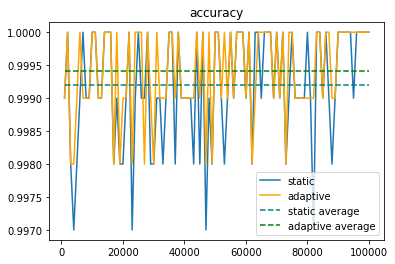

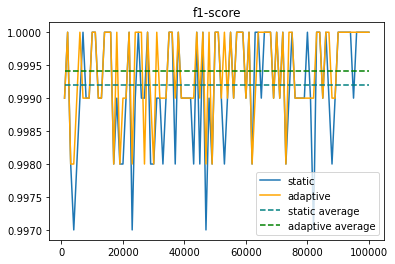

In [64]:
#num_of_iterations = 100
#window_size = 1000
#adaptive,static = kafka_stream(num_of_iterations,window_size,iot_data,iot_consumer,'multi')

print("Average of accuracy for adaptive model :"+str(statistics.mean(adaptive['accuracy'])))
print("Average of accuracy for static model :"+str(statistics.mean(static['accuracy'])))
print("")
print("Average of f1-score for adaptive model :"+str(statistics.mean(adaptive['f1-score'])))
print("Average of f1-score for static model :"+str(statistics.mean(static['f1-score'])))

plot_performance_metrics([adaptive,static],num_of_iterations,window_size)